In [1]:
import stlearn as st
import scanpy as sc
import pandas as pd
import re
import numpy as np

from collections import Counter
from scipy.sparse import csr_matrix
import anndata as ad
import seaborn as sns
#import harmonypy as hm
from matplotlib import pyplot as plt
from stlearn.spatials.clustering import localization
from scipy.stats import spearmanr

import gseapy as gp
from matplotlib.colors import LogNorm


plt.rcParams['figure.figsize'] = [6, 6]

C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\tools\microenv\cci\het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


# Helping functions 

In [2]:
# Function to remove outliers
def remove_outliers_function(df, outliers_percentage = 0.02):
    # Calculate the lower and upper percentile for each column
    lower_percentile = df.quantile(outliers_percentage/2)
    upper_percentile = df.quantile(1- outliers_percentage/2)
    
    # Filter the DataFrame to keep only the rows within the percentiles
    df_filtered = df.apply(lambda x: x[(x >= lower_percentile[x.name]) & (x <= upper_percentile[x.name])])
    
    # Drop rows with any NaN values (which were outliers)
    df_filtered = df_filtered.dropna()
    
    return df_filtered

def preprocess(adata, louvain_resolution, n_top_genes = 2000, n_comps = 50, diffmap = True, remove_outliers = True, scale = True, outliers_percentage = 0.02):
    """
    Preprocess the data. Be carefull about the order in which diffmap is called relative to other functions
    """

    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    # Keep raw data
    adata.raw = adata
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)

    if scale == True:
        sc.pp.scale(adata)

    
    sc.pp.pca(adata, n_comps = n_comps, random_state=0)

    if remove_outliers == True:
        PCs = pd.DataFrame(adata.obsm['X_pca'])
        PCs.index = adata.obs_names
        non_outliers = remove_outliers_function(PCs, outliers_percentage = outliers_percentage).index
        adata = adata[non_outliers]    
        sc.pp.pca(adata, n_comps = n_comps, random_state=0)

    sc.pp.neighbors(adata, use_rep="X_pca", random_state=0)

    if diffmap == True:
        sc.tl.diffmap(adata, n_comps = n_comps, random_state=0)
        sc.pp.neighbors(adata, use_rep="X_diffmap", random_state=0)
        
    st.tl.clustering.louvain(adata,random_state=0, resolution = louvain_resolution)

    return adata

def filter_cells(adata, obs_name, threshold):
    """
    Rename the clusters to fix their bug that the clusters need to be called 0,1,2,3,...
    """
    counts = adata.obs[obs_name].value_counts()
    filtered_categories = counts[counts >= threshold].index
    adata = adata[adata.obs[obs_name].isin(filtered_categories)]

    return(adata)

def get_rank_cor_drug(adata, screening_genes=None):
    
    tmp = adata.uns['drug2cell'].copy()
    tmp = tmp.to_df()
    tmp.columns = list(adata.uns['drug2cell'].var.index)

    if screening_genes != None:
        tmp = tmp[screening_genes]
    dpt = adata.obs["dpt_pseudotime"].values
    drugs = []
    score = []
    pvalue = []
    for drug in list(adata.uns['drug2cell'].var.index):
        drugs.append(drug)
        score.append(spearmanr(tmp[drug].values, dpt)[0])
        pvalue.append(spearmanr(tmp[drug].values, dpt)[1])
    import pandas as pd

    final = pd.DataFrame({"drug": drugs, "score": score, "p-value": pvalue})
    return final

def get_rank_cor_drug_pseudotime(adata, screening_genes=None):
    
    tmp = tmp = adata.to_df()

    if screening_genes != None:
        tmp = tmp[screening_genes]
    
    dpt = adata.obs["dpt_pseudotime"].values
    genes = []
    score = []
    pvalue = []
    for gene in list(adata.var.index):
        genes.append(gene)
        score.append(spearmanr(tmp[gene].values, dpt)[0])
        pvalue.append(spearmanr(tmp[gene].values, dpt)[1])
    import pandas as pd

    final = pd.DataFrame({"gene": genes, "score": score, "p-value": pvalue})
    return final


def detect_pseudotime_markers_total(
    adata,
    use_label,
    cutoff_spearman=0.4,
    cutoff_pvalue=0.05,
    screening_genes=None,
    use_raw_count=False,
    GenesOrDrugs = "genes"
):
    """\
    Detect the genes driving pseudotime

    Parameters
    ----------
    adata
        Annotated data matrix.
    cutoff_spearman
        The threshold of correlation coefficient.
    cutoff_pvalue
        The threshold of p-value.
    screening_genes
        List of customised genes.
    use_raw_count
        True if user wants to use raw layer data.
    Returns
    -------
    Anndata
    """
    print(
        "Detecting the pseudotime markers"
    )
    query_adata = adata[adata.obs[use_label].notna(), :]

    if(GenesOrDrugs == 'drugs'):
        spearman_result = get_rank_cor_drug(
            query_adata, screening_genes=screening_genes
        )
        spearman_result = spearman_result[spearman_result["p-value"] < cutoff_pvalue]
        positive = spearman_result[spearman_result["score"] >= cutoff_spearman].sort_values(
            "score", ascending=False
        )
        negative = spearman_result[
            spearman_result["score"] <= cutoff_spearman * (-1)
        ].sort_values("score")
    
        result = pd.concat([positive, negative])
    
        adata.uns["corr_pseudotime_drugs"] = result
    
        print(
            "Transition drugs markers result is stored in adata.uns[corr_pseudotime]"
        )
    else:
        spearman_result = get_rank_cor_drug_pseudotime(
            query_adata, screening_genes=screening_genes
        )

        spearman_result = spearman_result[spearman_result["p-value"] < cutoff_pvalue]
        positive = spearman_result[spearman_result["score"] >= cutoff_spearman].sort_values(
            "score", ascending=False
        )
        negative = spearman_result[
            spearman_result["score"] <= cutoff_spearman * (-1)
        ].sort_values("score")
    
        result = pd.concat([positive, negative])
    
        adata.uns["corr_pseudotime"] = result
    
        print(
            "Transition gene markers result is stored in adata.uns[corr_pseudotime]"
        )
    

# Main script

In [350]:
"""
MEND160
threshold_spots = 10
paga_threshold = 0.5
eps = 20
n_top_genes = 2000
"""


n_comps = 10
n_top_genes = None
outliers_percentage = 0.005
sample = 'MEND156'
diffmap = True # If true, we run diffmap with the same amount of n_comps as we have in PCA, otherwise diffmap is used as part of sc.tl.dpt
paga_threshold = 0.05

input_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/'

In [351]:
adata = sc.read_h5ad(input_path + sample + '.h5ad')

CNV = pd.read_csv(input_path + sample + '_annotated2.csv', index_col = 0)

CNV.columns = ['barcode', 'Label']

#CNV['subclone'][CNV['class'] == 'normal'] = 0
adata.obs['Label_orig'] = CNV['Label']
adata = adata[~adata.obs['Label_orig'].isna()]


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


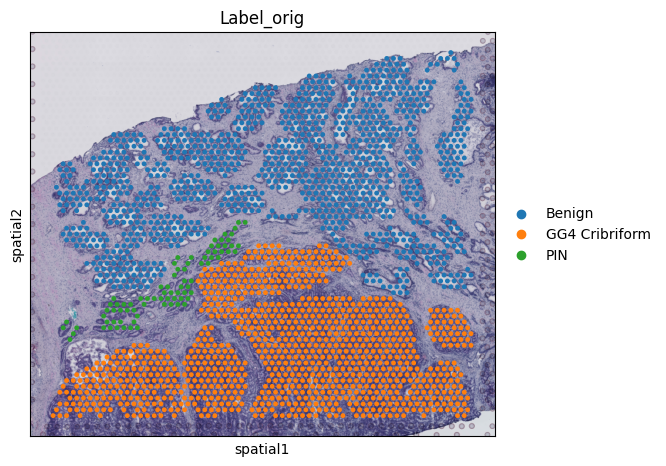

In [352]:
sc.pl.spatial(adata,
                # show first 8 cell types
                color=['Label_orig'],
                ncols=4, size=1.3,
                img_key="downscaled_fullres",
                # limit color scale at 99.2% quantile of cell abundance
                vmin=0, vmax=1,
                spot_size = adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres'],
                cmap="viridis"
                )

# Quality control

In [353]:
sc.pp.filter_cells(adata, min_genes = 100)
sc.pp.filter_genes(adata,min_cells=3)


# Remove spots with more than 20% mitochondrial genes --> indicates dead cells
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()


<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

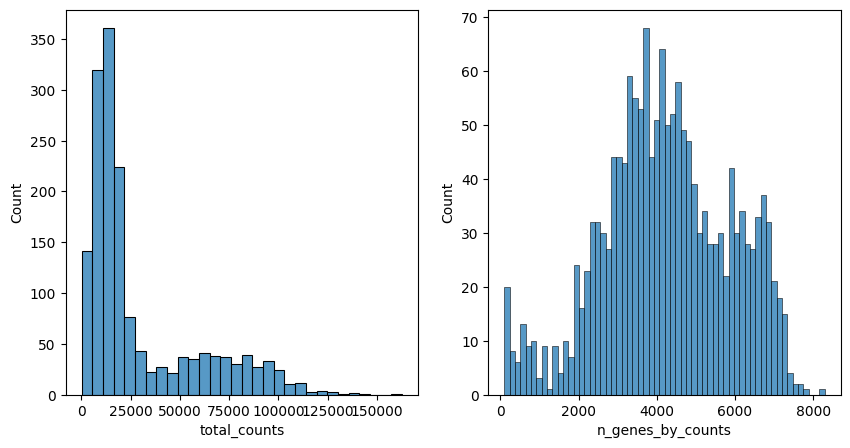

In [354]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

# Main pipeline

In [355]:
adata.layers['counts']=adata.X.copy()

adata = st.convert_scanpy(adata, use_quality = 'downscaled_fullres').copy()

adata = preprocess(adata, louvain_resolution = 0.5,  n_top_genes = n_top_genes, n_comps = n_comps,
                   diffmap = diffmap, remove_outliers = True, scale = True, outliers_percentage = outliers_percentage)


Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


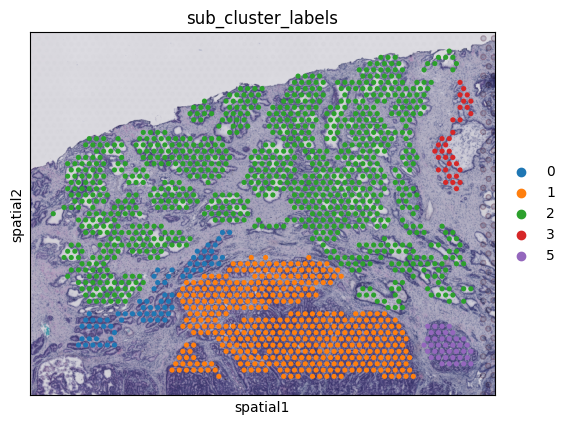

In [356]:
eps = 20 #How big subclusters will be created; The lower number the more subclusters
threshold_spots = 20 #Remove clusters with less then this many spots

adata.obs['Label_orig'] = (adata.obs['Label_orig']).astype('object').astype('category')

localization(adata, use_label='Label_orig', eps=eps)
adata = filter_cells(adata, 'sub_cluster_labels', threshold = threshold_spots)

sc.pl.spatial(adata,
                # show first 8 cell types
                color=['sub_cluster_labels'],
                ncols=4, size=1.3,
                img_key="downscaled_fullres",
                # limit color scale at 99.2% quantile of cell abundance
                vmin=0, vmax=1,
                spot_size = adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres'],
                cmap="viridis"
                )

In [357]:
root_cluster = 'Benign' # The cluster that corresponds to the early stage of cancer (benign cells)


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr


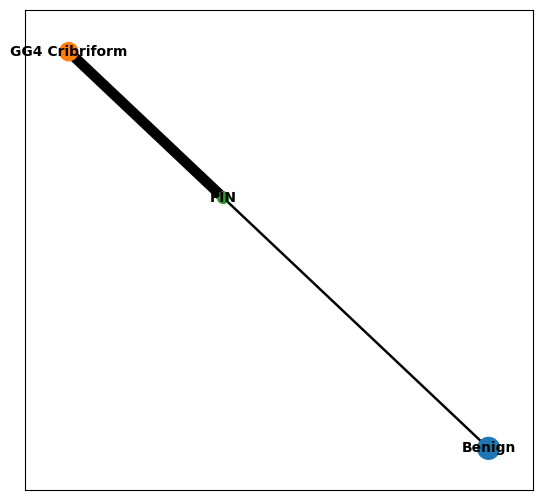

In [358]:
sc.tl.paga(adata, groups='Label_orig')
sc.pl.paga(adata, threshold=paga_threshold, show=False)
sc.tl.draw_graph(adata, init_pos="paga")

adata.uns["iroot"] = st.spatial.trajectory.set_root(adata,use_label='Label_orig',cluster=root_cluster, use_raw = False)

sc.tl.dpt(adata)


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


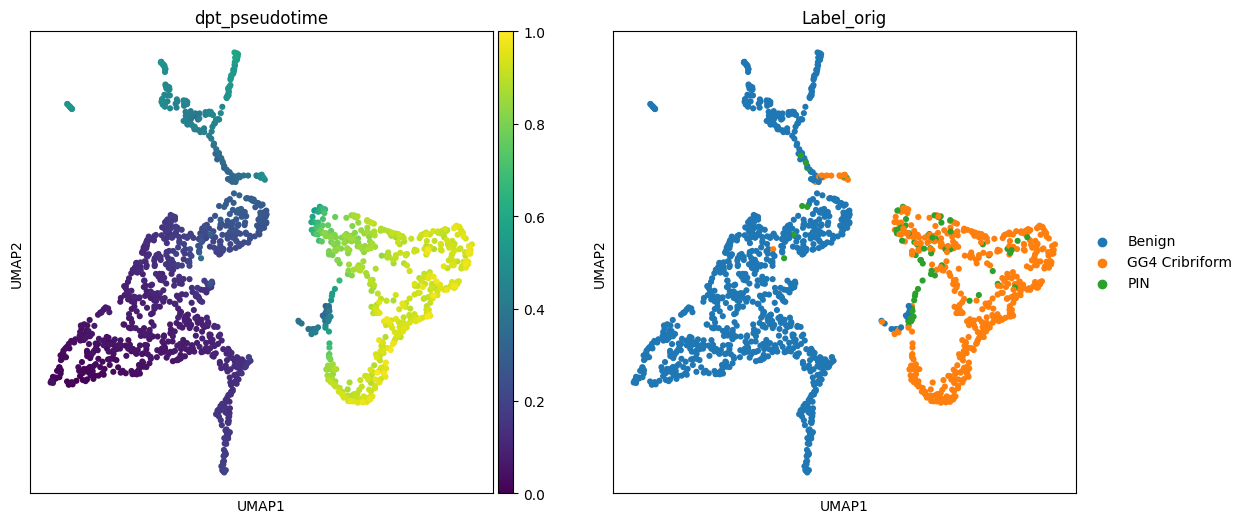

In [359]:
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['dpt_pseudotime', 'Label_orig'] )

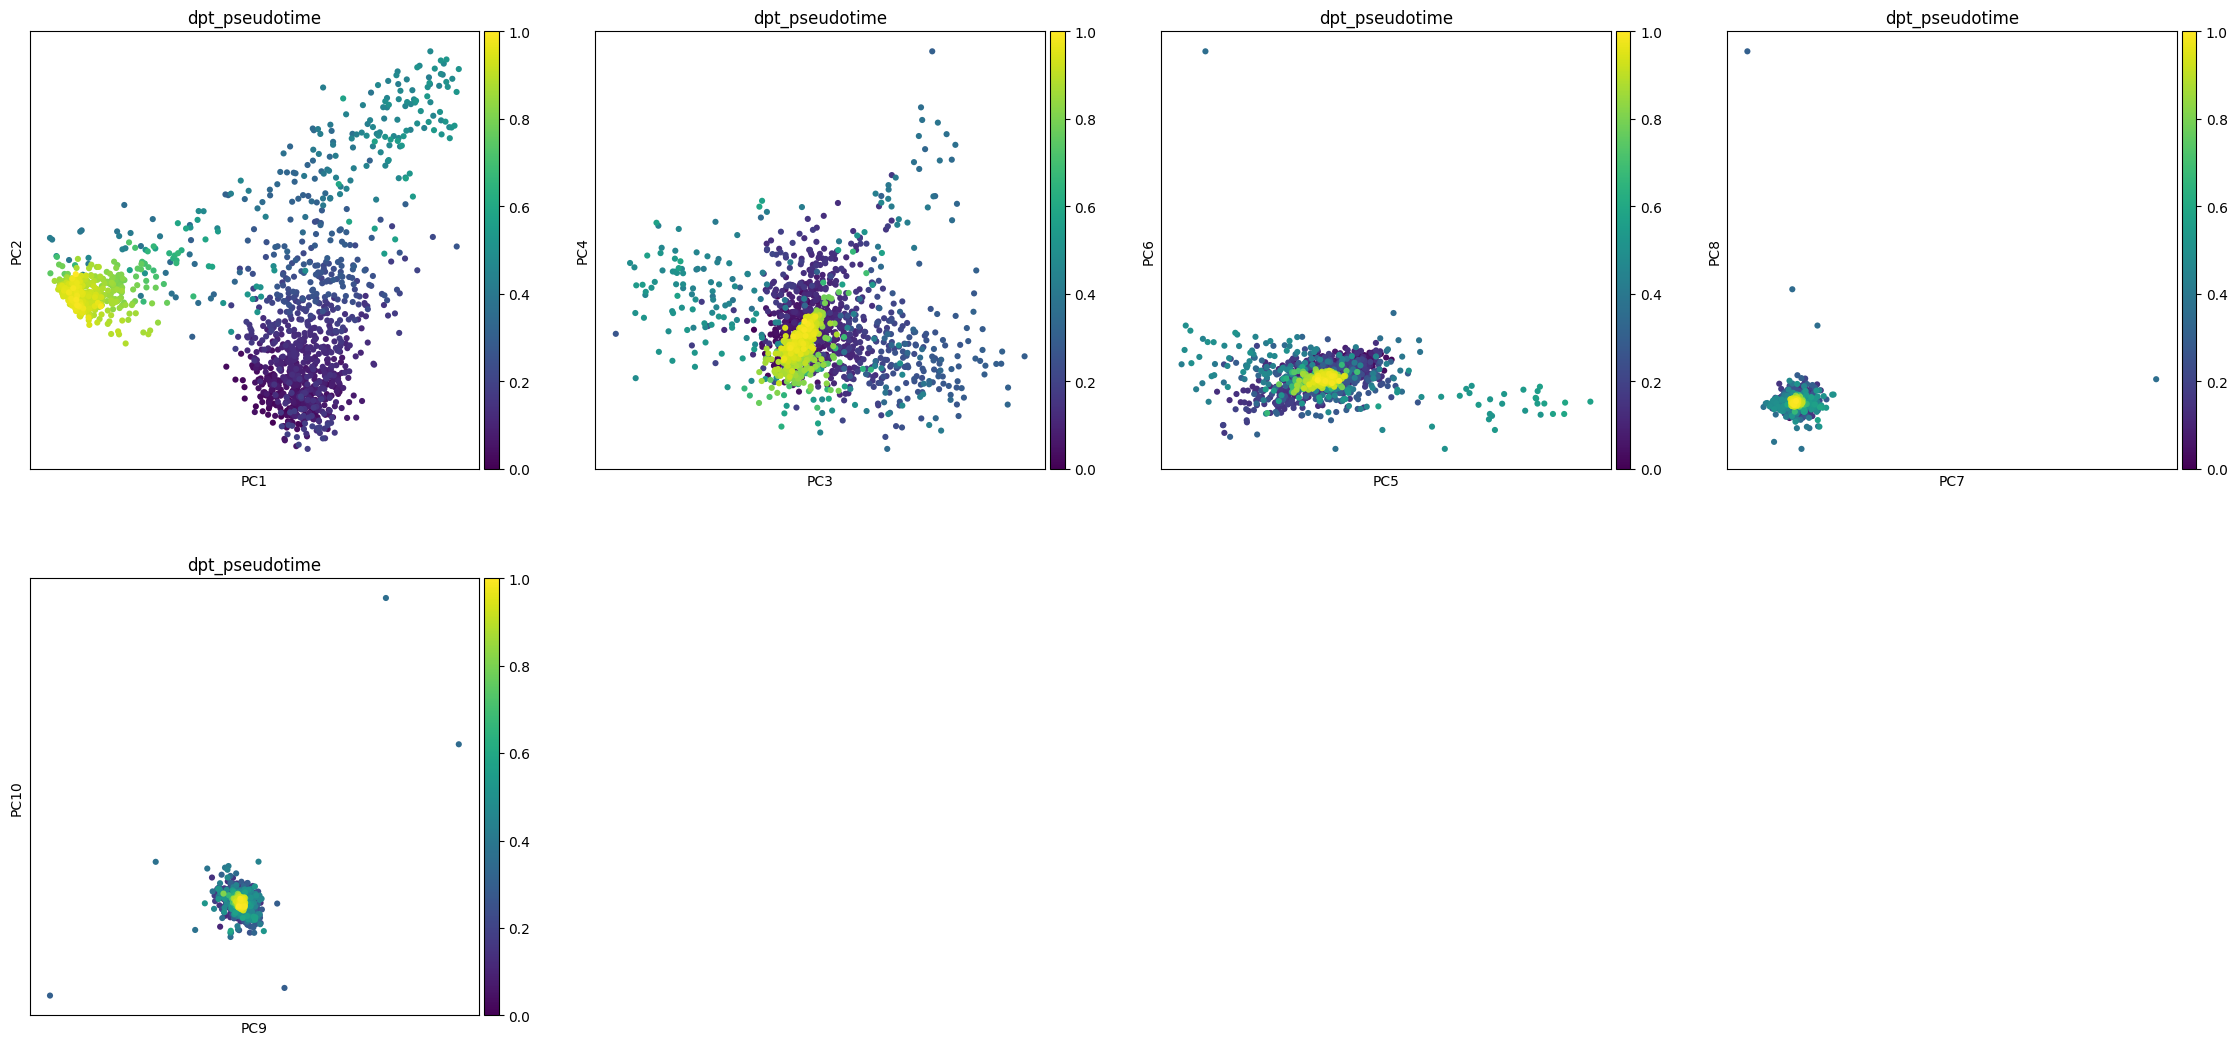

In [360]:
sc.pl.pca(adata, color="dpt_pseudotime", components=['1,2', '3,4', '5,6', '7,8', '9,10']) 

C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plot

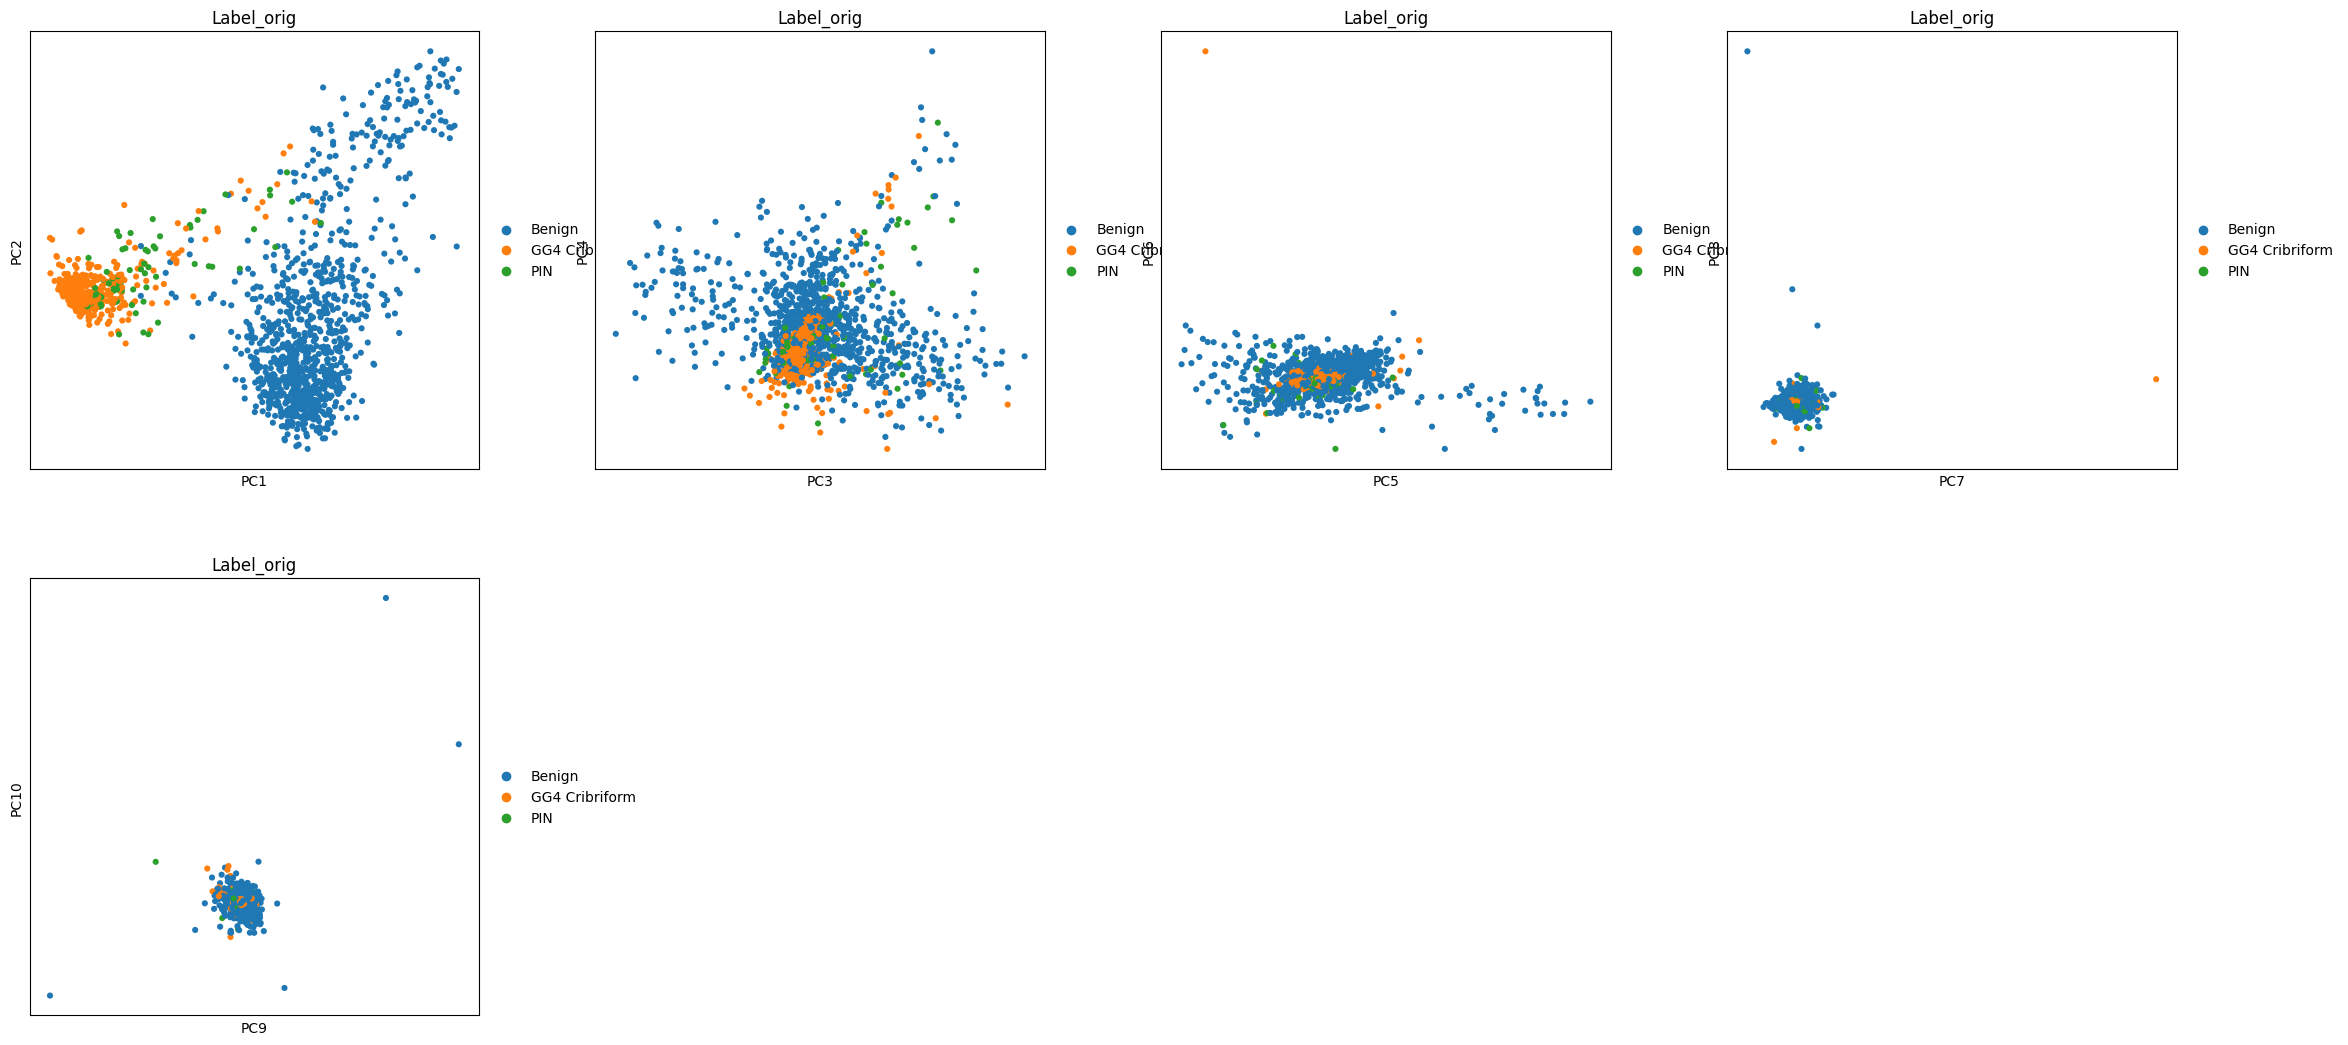

In [361]:
sc.pl.pca(adata, color="Label_orig", components=['1,2', '3,4', '5,6', '7,8', '9,10']) 

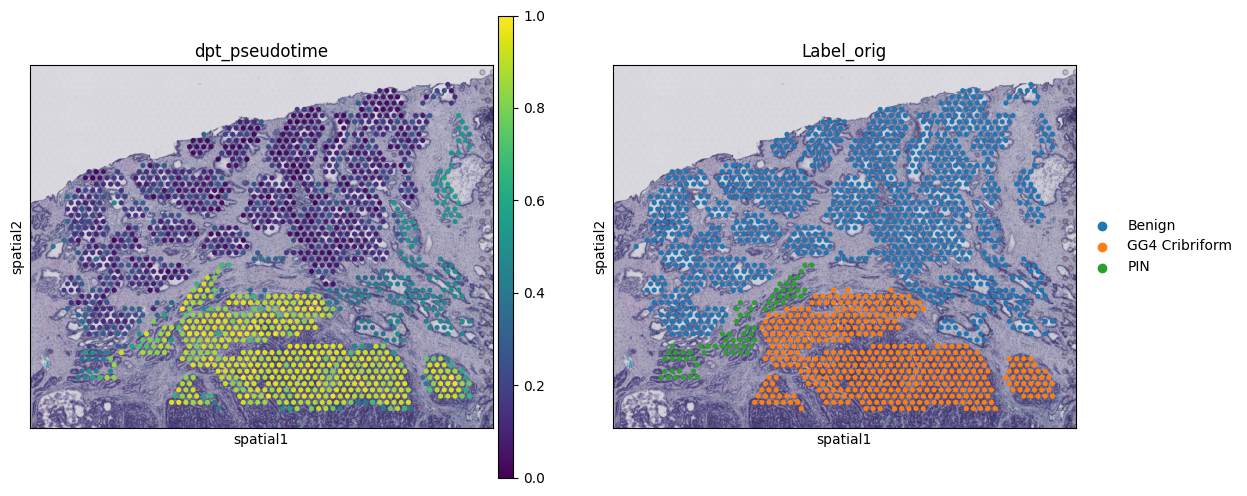

In [362]:
sc.pl.spatial(adata,
                # show first 8 cell types
                color=['dpt_pseudotime', 'Label_orig'],
                ncols=4, size=1.3,
                img_key="downscaled_fullres",
                # limit color scale at 99.2% quantile of cell abundance
                vmin=0, vmax=1,
                spot_size = adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres'],
                cmap="viridis"
                )

In [333]:
use_label = 'Label_orig'
detect_pseudotime_markers_total(adata,
                                use_label=use_label,
                                cutoff_spearman=0, #default 0.4
                                cutoff_pvalue=1, #default 0.05
                                use_raw_count=False)
correlations_pst = adata.uns["corr_pseudotime"].copy()
correlations_pst = correlations_pst[correlations_pst['p-value'] < 0.05]
correlations_pst = correlations_pst.sort_values(ascending = False,by="score",key= abs) 
correlations_pst
#correlations_pst[np.abs(correlations_pst['score']) > 0.5]

Detecting the pseudotime markers
Transition gene markers result is stored in adata.uns[corr_pseudotime]


,gene,score,p-value
6766,TRGC1,-0.666063,1.114497e-133
18212,FAM3B,-0.625926,1.157555e-113
18224,TFF3,-0.620342,4.163104e-111
8879,PCA3,-0.599166,7.220638e-102
15268,SNHG25,-0.597546,3.444897e-101
...,...,...,...
15339,MRPL58,-0.061003,4.976221e-02
3006,SH3BP4,-0.060979,4.985101e-02
3088,THUMPD3,0.060978,4.985564e-02
13155,SEMA6D,0.060944,4.998250e-02


In [334]:
pst_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/python/FilesPaths/MyPaths/GenesDrugsAllSpots/RemoveTrueTrue/'

correlations_pst.to_csv(pst_path + sample + '_summary_Genes_AllSpotsPseudotime.csv')